# Amplitude-to-noise ratio

author: laquitainesteeve@gmail.com

Purpose: describe trace amplitude-to-noise ratio

Execution time: 

## Setup

Create, activate and select virtual environment kernel `demo` from (envs/demo.yml):

```bash
python -m ipykernel install --user --name demo --display-name "demo" # create kernel
```

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import packages
import os
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface as si
from matplotlib import pyplot as plt;
import multiprocessing
import torch
import pandas as pd
import seaborn as sns
import matplotlib
import sys
print("spikeinterface version:", si.__version__)

# dandiset parameters
dandiset_id = '001250'
filepath_evoked = 'sub-demo-npx-bio-evoked/sub-demo-npx-bio-evoked_ecephys.nwb'
filepath_spont = 'sub-demo-npx-bio-spont/sub-demo-npx-bio-spont_ecephys.nwb'

# project path
proj_path = "/Users/steeve_laquitaine/Desktop/EPFL/2022_2024_bbp/spikebias/"
#proj_path = "/home/jovyan/steevelaquitaine/spikebias/"
os.chdir(proj_path)

# enable spike bias import
sys.path.insert(0, proj_path)

from src.nodes.utils import get_config
from src.nodes.validation import snr
from src.nodes.validation import amplitude

# evoked demo
cfg_e, param_cfg_e = get_config("silico_neuropixels", "npx_evoked").values() # config
FREQ_MIN_E = param_cfg_e["run"]["preprocessing"]["min_filter_freq"] # preprocessing parameters
FREQ_MAX_E = param_cfg_e["run"]["preprocessing"]["max_filter_freq"]

# spontaneous demo
cfg_s, param_cfg_s = get_config("silico_neuropixels", "npx_spont").values() # config
FREQ_MIN_S = param_cfg_s["run"]["preprocessing"]["min_filter_freq"] # preprocessing parameters
FREQ_MAX_S = param_cfg_s["run"]["preprocessing"]["max_filter_freq"]

# layer parameter
lyrs = ["L5"]

# plot parameters
FIG_SIZE = (1.8, 1.6)
COLOR_NS = [0.9, 0.14, 0.15]
COLOR_NE = [1, 0.49, 0]
N_BINS = 100 # bins for snr histogram
pm = {
    "linestyle": "-",
    "linewidth": 1,
    "marker": "None",
}

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spikeinterface version: 0.101.2
2025-04-06 10:42:36,339 - root - utils.py - get_config - INFO - Reading experiment config.
2025-04-06 10:42:36,460 - root - utils.py - get_config - INFO - Reading experiment config. - done
2025-04-06 10:42:36,462 - root - utils.py - get_config - INFO - Reading experiment config.
2025-04-06 10:42:36,552 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Load demo

In [ ]:
%%time

# EVOKED DEMO

with DandiAPIClient() as client: # download the extractors from Dandi archive
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath_evoked)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
RecordingE = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile") # get extractor
#RecordingE = spre.astype(RecordingE, "int16") # compress to int16 (like kilosorts)
RecordingE = spre.bandpass_filter(RecordingE, freq_min=FREQ_MIN_E, freq_max=FREQ_MAX_E)  # band-pass filter
RecordingE = spre.common_reference(RecordingE, reference="global", operator="median") # common reference
traces_ne = RecordingE.get_traces() # get trace array

# SPONTANEOUS DEMO

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath_spont)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
RecordingS = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile")
RecordingS = spre.astype(RecordingS, "int16")
RecordingS = spre.bandpass_filter(RecordingS, freq_min=FREQ_MIN_S, freq_max=FREQ_MAX_S)
RecordingS = spre.common_reference(RecordingS, reference="global", operator="median")
traces_ns = RecordingS.get_traces()

CPU times: user 32.2 s, sys: 13.9 s, total: 46.1 s
Wall time: 17min 57s


## Compute

In [ ]:
%%time 

# evoked
traces_ne = RecordingE.get_traces() # get trace array
site_ly_ne = RecordingE.get_property("layers") # get layers
sites_ne = np.where(np.isin(site_ly_ne, lyrs))[0]

# spontaneous
traces_ns = RecordingS.get_traces() # get trace array
site_ly_ns = RecordingS.get_property("layers") # get layers
sites_ns = np.where(np.isin(site_ly_ns, lyrs))[0]

# compute snrs
snr_ne = snr.get_snrs_parallel(traces_ne[:, sites_ne]).astype(np.float32)
max_anr_e = np.max(snr_ne)
min_anr_e = np.min(snr_ne)
snr_ns = snr.get_snrs_parallel(traces_ns[:, sites_ns]).astype(np.float32)
max_anr_s = np.max(snr_ns)
min_anr_s = np.min(snr_ns)

# get the common bins across all experiments
# gather the mins and maxs computed from all nodes and 
# compute the common bins on node 0
anr_max = np.max([max_anr_e, max_anr_s])
anr_min = np.min([min_anr_e, min_anr_s])
step = (anr_max - anr_min) / N_BINS
bins = np.arange(anr_min, anr_max + step / 2, step)

# compute summary statistics
mean_ne, ci_ne, _ = amplitude.get_snr_pdfs(snr_ne, bins)
mean_ne, ci_ne, _ = amplitude.get_snr_pdfs(snr_ns, bins)

## Plot

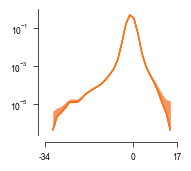

In [19]:
# plot
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot
ax = amplitude.plot_anr_pdf_l5_demo(
    ax,
    mean_ne,
    mean_ne,
    ci_ne,
    ci_ne,
    bins,
    COLOR_NS,
    COLOR_NE,
    pm,
)

xmin, xmax = ax.get_xlim()
ax.set_xticks([np.floor(xmin).astype(int), 0, np.ceil(xmax).astype(int)], [np.floor(xmin).astype(int), 0, np.ceil(xmax).astype(int)])
ax.set_xlim([np.floor(xmin), np.ceil(xmax)])

# tighten
fig.tight_layout(**tight_layout_cfg)